# PyTorch NN Training Code
## TORCH.NN이 실제로 무엇인가요?
PyTorch는 신경망(Neural Network)를 생성하고 학습 시키는 것을 도와주기 위해서 `torch.nn, torch.optim, Dataset, DataLoader`와 같은 잘 디자인된 모듈과 클래스들을 제공  
이들의 성능을 최대한 활용하고 커스텀하기 위해서, 정확히 이들이 어떤 작업을 수행하는지 이해할 필요가 있음  

파이토치의 기본적인 기능인 텐서(Tensor)만을 사용해 MNIST에 대해 기초적인 신경망을 학습 시킬 예정  
이후, 점차적으로 피쳐를 추가하면서 정확히 각 부분이 어떤 일을 하는지 그리고 어떻게 코드를 간결하고 유연하게 만드는지 알아봄

## MNIST 데이터 준비

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH/"mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

각 이미지는 28*28 형태이고, 784 크기를 가진 하나의 행으로 저장되어 있음

(50000, 784)


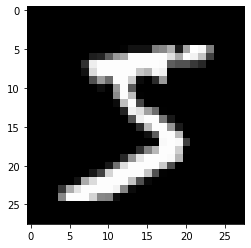

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch는 numpy 배열 보다는 `torch.tensor`를 사용하므로, 데이터를 변환해줌

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape
print(x_train.shape)
print(y_train.min(), y_train.max())

torch.Size([50000, 784])
tensor(0) tensor(9)


## torch.nn 없이 밑바닥부터 신경망 만들기
PyTorch 텐서 연산만으로 첫 모델을 생성  
간단한 선형 모델의 가중치(weights)와 절편(bias)을 생성하기 위해서 랜덤 또는 0으로만 이뤄진 텐서를 생성하는 메서드를 사용  

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

PyTorch의 기울기를 자동으로 계산해주는 기능 덕분에, Python 표준 함수를 모델로 사용할 수 있음  
-> 간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드캐스트(broadcast) 덧셈을 사용  
-> 활성화 함수가 필요하므로, log_softmax를 구현하고 사용  

In [7]:
def log_softmax(x):
    return x-x.exp().sum(-1).log().unsqueeze(-1)
def model(xb):
    return log_softmax(xb@weights+bias)

In [8]:
# 배치 사이즈
bs = 64
# 미니 배치 추출
xb = x_train[0:bs]
# 순전파: 예측
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.0617, -1.9652, -2.9064, -2.4975, -2.1835, -2.3261, -2.2209, -2.2271,
        -2.3912, -2.5576], grad_fn=<SelectBackward0>) torch.Size([64, 10])


`preds` 텐서(tensor)는 텐서 값 외에도, 또한 기울기 함수(gradient function)를 담고 있음 -> 역전파(backpropagation)을 위해 사용  

손실 함수(loss function)로 사용하기 위한 음의 로그 우도(negative log-likelihood)를 구현

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

가중치를 무작위로 설정한 모델의 손실 검증 (역전파 이후에 개선된 모습을 확인할 수 있음)

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3769, grad_fn=<NegBackward0>)


모델의 정확도(accuarcy)를 계산하기 위한 함수

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [12]:
print(accuracy(preds, yb))

tensor(0.0469)


### Training Loop
매 반복마다 수행할 작업 목록
- 데이터의 미니배치 선택
- 모델을 이용해 예측 수행
- 손실 계산
- `loss.backward()`를 이용해 모델의 기울기(`weights와 bias`) 업데이트

`torch.no_grad()` 내에서 실행하는 이유는, 다음 기울기 계산에 기록되지 원하지 않기때문

In [13]:
from IPython.core.debugger import set_trace

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        # 각 매개 변수에 대한 기우기들을 수동으로 제거하고 업데이트
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

제일 간단하 신경망의 모든 것을 밑바닥부터 생성하고 훈련 (은닉층이 없기 때문에, 로지스틱 회귀(logistic regression)임)

In [14]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0784, grad_fn=<NegBackward0>) tensor(1.)


손실은 감소하고 정확도는 증가했음

## torch.nn.functional 사용하기
PyTorch의 `nn` 클래스를 이용해 위 코드를 리팩토링함  
- 활성화, 손실 함수를 `torch.nn.functional`의 함수로 대체

In [15]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb@weights+bias

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0784, grad_fn=<NllLossBackward0>) tensor(1.)


## nn.Module을 이용하여 리팩토링 하기
더 명확하고 간결한 훈련 루프를 위해 `nn.Module` 및 `nn.parameter`를 사용

In [19]:
from turtle import forward
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [20]:
model = Mnist_Logistic()

In [21]:
print(loss_func(model(xb), yb))

tensor(2.3382, grad_fn=<NllLossBackward0>)


```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```
위 코드를 개선

In [23]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()